# The NAND Programming Language

_Version:_ 0.2

The NAND programming language was designed to accompany the upcoming book ["Introduction to Theoretical Computer Science"](http://introtcs.org). This is an appendix to this book, which is also available online as a Jupyter notebook.

The NAND programming language is part of a family of languages:

* __NAND:__  The NAND programming language is equivalent in expressive power to _Boolean circuits_. Specifically NAND programs are straightline programs with the _NAND_ operation, which are equivalent to Boolean circuits with _NAND_ gates.

* __NAND++:__ The NAND++ programming language is equivalent in expressive power to _Turing Machines_. NAND++ programs are obtained by adding _loops_ and _unbounded arrays_ to NAND programs. Specifically, NAND++ programs can be thought of as capturing _oblivious single tape Turing Machines_, that are polynomially equivalent to all other standard variants of Turing Machines and Turing-equivalent models of computation. 

* __NAND<<:__ The NAND<< programing language is a formalization of _RAM Machines_. NAND<< programs are obtained by adding integer-valued variables and arrays, and the standard "C type" operations on them, as well as _indirect indexing_ of arrays via integer variables. NAND<< programs are equivalent up to polylogarithmic terms to standard models of RAM machines, and up to polynomial terms with NAND++ and all other standard Turing-equivalent models.

* __QNAND:__ QNAND is only used in a single chapter of the book, and is meant to capture _Quantum Boolean Circuits_ and so can be used to define the class __BQP__ of polyonmial time quantum computaiton.


## Syntax of NAND programs 

This notebook/appendix is concerned with the first and simplest of these languages: the _NAND Programming Languages_. A NAND program consists of a sequence of lines, each of the following form:

```foo := NAND(bar,blah)```

where `foo`, `bar` and `blah` are variable identifiers. 

We have two special types of variables: _input variables_ have the form `X[` $i$ `]` where $i$ is a natural number, and _output variables_ have the form `Y[`$j$ `]` where $j$ is a natural number. When a NAND program is _executed_ on input $x \in \{0,1\}^n$, the variable `X[`$i$ `]` is assigned the value $x_i$ for all $i\in [n]$. The _output_ of the program is the list of $m$ values  `Y[0]`$\ldots$ `Y[`$m-1$ `]`, where $m-1$ is the largest index for which the variable `Y[`$m-1$ `]` is assigned a value in the program.

Here is an example of a NAND program:

In [76]:
xor = r'''
u = NAND(X[0],X[1])
v = NAND(X[0],u)
w = NAND(X[1],u)
Y[0] = NAND(v,w)
'''

To evaluate this program on inputs $x_0,x_1 \in \{0,1\}$, we can use a simple _Python_ function that would keep track of the values assigned to variables. 

In [102]:
def NAND(x,y):
    """Compute the NAND of two 0/1 valued variables."""
    return 1 - x*y

In [79]:
import re
def numinout(prog):
    '''Compute the number of inputs and outputs of a NAND program, given as a string of source code.'''
    n = max([int(s[2:-1]) for s in re.findall(r'X\[\d+\]',prog)])+1
    m = max([int(s[2:-1]) for s in re.findall(r'Y\[\d+\]',prog)])+1
    return n,m

numinout(xor)     

(2, 1)

In [80]:
from collections import defaultdict

def EVAL(prog,x):
    """Evaluate NAND program prog on input x."""
    (n,m) = numinout(prog)
    vartable = defaultdict(int) # dictionary where missing entries are automatically zero
    for i in range(n): vartable[f'X[{i}]']=x[i]
    for line in filter(None,re.split('\n+',prog)): # split into lines
        foo,bar,blah, = filter(None,re.split('\s*=\s*NAND\s*\(|\,|\)\s*|\s+',line)) # split to components of a line
        vartable[foo] =  NAND(vartable[bar],vartable[blah])
    return [vartable[f'Y[{j}]'] for j in range(m)]

In [81]:
EVAL(xor,[1,1])

[0]

While we could easily write a "NAND interpreter" in any programming language, by design a NAND program uses valid Python code. So we can also write NAND programs as python functions:

In [83]:
def XOR(a,b):
    t1 = NAND(a,b)
    t2 = NAND(a,t1)
    t3 = NAND(b,t1)
    return NAND(t2,t3)

XOR(0,1)

1

We can translate such a function into standard NAND code using a simple trick. We will "override" the NAND function to take a pair of strings `bar`, `blah` instead of integers as input and generate the line of code `foo = NAND(bar,blah)` instead of computing the NAND function.

In [106]:
from inspect import signature
def numarguments(f):
    """Number of arguments a Python function takes."""
    return len(signature(f).parameters)

def nandcode(f):
    n = numarguments(f)
    counter = 0 # to ensure unique temporary variables.
    code = ''
    global NAND
    def tempNAND(bar,blah):
        nonlocal code, counter 
        var = f'Temp[{counter}]'
        counter += 1
        code += f'{var} = NAND({bar},{blah})\n'
        return var
    
    NAND , tempNAND = tempNAND, NAND # Override NAND with its temporary version 
    # (this is a hack and won't play nicely with exceptions or multithreading)
    outputs = f(*[f'X[{i}]' for i in range(n)]) # execute f on the strings "X[0]", "X[1]", ...
    NAND , tempNAND = tempNAND, NAND # Restore original NAND
    
    if type(outputs)==str: outputs = [outputs] # make single output into singleton list
        
    for j in range(len(outputs)):
        code = code.replace(outputs[j],f'Y[{j}]')
    return code

print(nandcode(XOR))

Temp[0] = NAND(X[0],X[1])
Temp[1] = NAND(X[0],Temp[0])
Temp[2] = NAND(X[1],Temp[0])
Y[0] = NAND(Temp[1],Temp[2])



In [105]:
XOR(1,1)

0

## Syntactic sugar

NAND is pretty bare bones, and writing NAND code directly gets real old real fast. However, we can use "syntactic  sugar" to make it a little less tedious. For example we can use function definitions to avoid copying again and again repetitive code.

We will use the Python-like syntax of `def func(...):` to define functions and so we can write the XOR on 4 bits function as follows:

In [107]:
def XOR4(a,b,c,d):
    return XOR(XOR(a,b),XOR(c,d))

XOR4(0,1,0,1)

0

To verify that this is indeed merely "syntactic sugar" and this can be translated to pure NAND we can use our `nandcode` function:

In [108]:
print(nandcode(XOR4))

Temp[0] = NAND(X[0],X[1])
Temp[1] = NAND(X[0],Temp[0])
Temp[2] = NAND(X[1],Temp[0])
Temp[3] = NAND(Temp[1],Temp[2])
Temp[4] = NAND(X[2],X[3])
Temp[5] = NAND(X[2],Temp[4])
Temp[6] = NAND(X[3],Temp[4])
Temp[7] = NAND(Temp[5],Temp[6])
Temp[8] = NAND(Temp[3],Temp[7])
Temp[9] = NAND(Temp[3],Temp[8])
Temp[10] = NAND(Temp[7],Temp[8])
Y[0] = NAND(Temp[9],Temp[10])



Once we have this, we can also define other functions such as AND, OR, NOT, and also the IF function that on input `cond`, `a` and `b` returns `a` if `cond` equals 1 and `b` otherwise.

In [134]:
def NOT(a):
    return NAND(a,a)

def AND(a,b):
    return NOT(NAND(a,b))

def OR(a,b):
    return NAND(NOT(a),NOT(b))

def IF(cond,first,sec):
    temp1 = AND(cond,first) # zero if cond=0, otherwise first
    temp2 = AND(NOT(cond),sec) # zero if cond=1, otherwise second
    return OR(temp1,temp2)

def one(a):
    return NAND(a,NOT(a))

def zero(a):
    return NOT(one(a))

def COPY(a):
    return NOT(NOT(a))

IF(0,1,0)

0

We can use more python-inspired syntactic sugar:

In [139]:
def increment(X): # increment integer given in binary representation
    n = len(X)
    Y = ["*"]*(n+1) # will be overwritten anyway
    carry = one(X[0])
    for i in range(n):
        Y[i] = XOR(X[i],carry)
        carry = AND(X[i],carry)
    Y[n] = COPY(carry)
    return Y

def inc5(a,b,c,d,e):
    return increment([a,b,c,d,e])

In [140]:
inc5(1,1,0,0,0)

[0, 0, 1, 0, 0, 0]

In [141]:
print(nandcode(inc5))

Temp[0] = NAND(X[0],X[0])
Temp[1] = NAND(X[0],Temp[0])
Temp[2] = NAND(X[0],Temp[1])
Temp[3] = NAND(X[0],Temp[2])
Temp[4] = NAND(Temp[1],Temp[2])
Y[0] = NAND(Temp[3],Temp[4])
Temp[6] = NAND(X[0],Temp[1])
Temp[7] = NAND(Temp[6],Temp[6])
Temp[8] = NAND(X[1],Temp[7])
Temp[9] = NAND(X[1],Temp[8])
Temp[10] = NAND(Temp[7],Temp[8])
Y[1] = NAND(Temp[9],Temp[10])
Temp[12] = NAND(X[1],Temp[7])
Temp[13] = NAND(Temp[12],Temp[12])
Temp[14] = NAND(X[2],Temp[13])
Temp[15] = NAND(X[2],Temp[14])
Temp[16] = NAND(Temp[13],Temp[14])
Y[2] = NAND(Temp[15],Temp[16])
Temp[18] = NAND(X[2],Temp[13])
Temp[19] = NAND(Temp[18],Temp[18])
Temp[20] = NAND(X[3],Temp[19])
Temp[21] = NAND(X[3],Temp[20])
Temp[22] = NAND(Temp[19],Temp[20])
Y[3] = NAND(Temp[21],Temp[22])
Temp[24] = NAND(X[3],Temp[19])
Temp[25] = NAND(Temp[24],Temp[24])
Temp[26] = NAND(X[4],Temp[25])
Temp[27] = NAND(X[4],Temp[26])
Temp[28] = NAND(Temp[25],Temp[26])
Y[4] = NAND(Temp[27],Temp[28])
Temp[30] = NAND(X[4],Temp[25])
Temp[31] = NAND(Temp[30],Temp[30

In [144]:
EVAL(nandcode(inc5),[1,0,1,0,0])

[0, 1, 1, 0, 0, 0]

We can create functions such as inc5 for every n via a little Python trickery:

In [231]:
def restrict(f,n):
    """Create function that restricts the function f to exactly n inputs"""
    args = ", ".join(f'arg{i}' for i in range(n))
    exec(rf'''
def _temp({args}):
    return {f.__name__}([{args}])
    ''',globals())
    return _temp


In [234]:

inc7 = restrict(increment,7)

inc7(1,1,1,0,0,0,1)

[0, 0, 0, 1, 0, 0, 1, 0]

In [170]:
print(nandcode(inc7))

Temp[0] = NAND(X[0],X[0])
Temp[1] = NAND(X[0],Temp[0])
Temp[2] = NAND(X[0],Temp[1])
Temp[3] = NAND(X[0],Temp[2])
Temp[4] = NAND(Temp[1],Temp[2])
Y[0] = NAND(Temp[3],Temp[4])
Temp[6] = NAND(X[0],Temp[1])
Temp[7] = NAND(Temp[6],Temp[6])
Temp[8] = NAND(X[1],Temp[7])
Temp[9] = NAND(X[1],Temp[8])
Temp[10] = NAND(Temp[7],Temp[8])
Y[1] = NAND(Temp[9],Temp[10])
Temp[12] = NAND(X[1],Temp[7])
Temp[13] = NAND(Temp[12],Temp[12])
Temp[14] = NAND(X[2],Temp[13])
Temp[15] = NAND(X[2],Temp[14])
Temp[16] = NAND(Temp[13],Temp[14])
Y[2] = NAND(Temp[15],Temp[16])
Temp[18] = NAND(X[2],Temp[13])
Temp[19] = NAND(Temp[18],Temp[18])
Temp[20] = NAND(X[3],Temp[19])
Temp[21] = NAND(X[3],Temp[20])
Temp[22] = NAND(Temp[19],Temp[20])
Y[3] = NAND(Temp[21],Temp[22])
Temp[24] = NAND(X[3],Temp[19])
Temp[25] = NAND(Temp[24],Temp[24])
Temp[26] = NAND(X[4],Temp[25])
Temp[27] = NAND(X[4],Temp[26])
Temp[28] = NAND(Temp[25],Temp[26])
Y[4] = NAND(Temp[27],Temp[28])
Temp[30] = NAND(X[4],Temp[25])
Temp[31] = NAND(Temp[30],Temp[30

## NAND Programs and circuits

NAND programs are equivalent to the model of Boolean circuits. We can present the graph corresponding to a NAND function using ideas similar to those we used to print the code

In [194]:
import graphviz
from graphviz import Graph
from graphviz import Digraph

def nandcircuit(f):
    """Compute the graph representating a NAND circuit for a NAND program, given as a Python function."""
    n = numarguments(f)
    counter = 0 # to ensure unique temporary variables.
    G = Digraph()
  
    
    global NAND
    def tempNAND(bar,blah):
        nonlocal G, counter 
        var = f'Temp[{counter}]'
        counter += 1
        G.node(var,label="∧\u0305")
        G.edge(bar,var)
        G.edge(blah,var)
        return var
    
    for i in range(n):
        G.node(f'X[{i}]',label=f'X[{i}]', fontcolor='blue',shape='square') 
        
    NAND , tempNAND = tempNAND, NAND # Override NAND with its temporary version 
    # (this is a hack and won't play nicely with exceptions or multithreading)
    outputs = f(*[f'X[{i}]' for i in range(n)]) # execute f on the strings "X[0]", "X[1]", ...
    NAND , tempNAND = tempNAND, NAND # Restore original NAND
    
    if type(outputs)==str: outputs = [outputs] # make single output into singleton list
        
    for j in range(len(outputs)):
        G.node(outputs[j],label=f'Y[{j}]',fontcolor='red',shape='diamond')
    return G

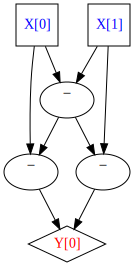

In [195]:
nandcircuit(XOR)

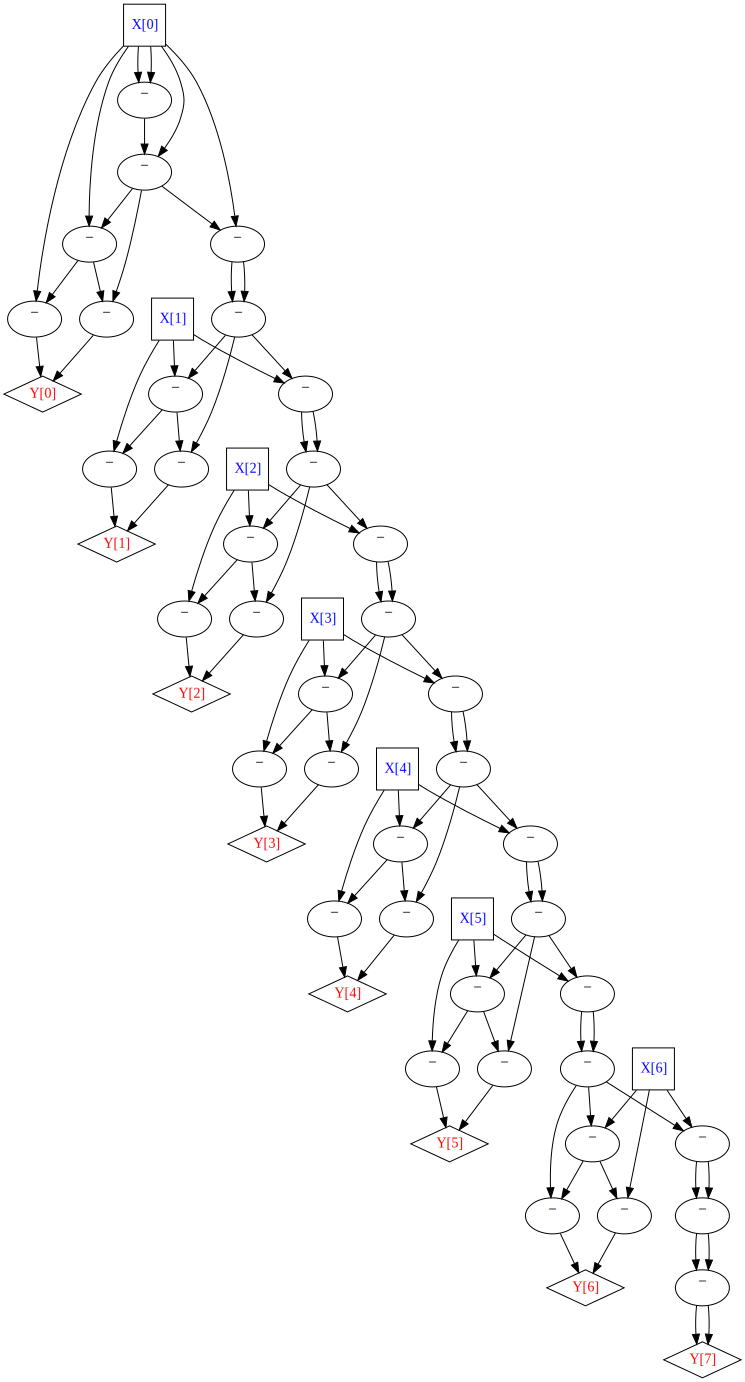

In [196]:
nandcircuit(inc7)

## Computing every function

It turns out that we can compute _every_ function $f:\{0,1\}^n \rightarrow \{0,1\}$ by some NAND program.

The crucial element for that is the function `LOOKUP` that on input an index $i\in [n]$ (represented as a string of length $\log n$) and a table $T\in \{0,1\}^n$, outputs $t_i$.

In [226]:
def LOOKUP(i,T):
    l = len(i)
    if l==1:
        return IF(i[0],T[1],T[0])
    return IF(i[l-1],LOOKUP(i[:-1],T[2**(l-1):]),LOOKUP(i[:-1],T[:2**(l-1)]))

LOOKUP([1,1,1],[0,1,1,0,1,1,0,1])

1

We can extract the NAND code of LOOKUP using the usual tricks.

In [239]:
# generalize restrict to handle functions that take more than one array
def restrict(f,*numinputs):
    """Create function that restricts the function f to exactly given input lengths n0,n1,..."""
    k = len(numinputs)
    args = [""]*k
    
    for i in range(k):
        args[i] = ", ".join(f'arg_{i}_{j}' for j in range(numinputs[i]))
    sig = ", ".join(args)
    call = ", ".join(f"[{args[i]}]" for i in range(k))
    exec(rf'''
def _temp({sig}):
    return {f.__name__}({call})
    ''',globals())
    return _temp


In [240]:
def funclookup(l):
    return restrict(LOOKUP,l,2**l)

In [241]:
funclookup(3)(1,1,1,0,1,1,0,1,1,0,1)

1

In [242]:
print(nandcode(funclookup(3)))

Temp[0] = NAND(X[0],X[10])
Temp[1] = NAND(Temp[0],Temp[0])
Temp[2] = NAND(X[0],X[0])
Temp[3] = NAND(Temp[2],X[9])
Temp[4] = NAND(Temp[3],Temp[3])
Temp[5] = NAND(Temp[1],Temp[1])
Temp[6] = NAND(Temp[4],Temp[4])
Temp[7] = NAND(Temp[5],Temp[6])
Temp[8] = NAND(X[0],X[8])
Temp[9] = NAND(Temp[8],Temp[8])
Temp[10] = NAND(X[0],X[0])
Temp[11] = NAND(Temp[10],X[7])
Temp[12] = NAND(Temp[11],Temp[11])
Temp[13] = NAND(Temp[9],Temp[9])
Temp[14] = NAND(Temp[12],Temp[12])
Temp[15] = NAND(Temp[13],Temp[14])
Temp[16] = NAND(X[1],Temp[7])
Temp[17] = NAND(Temp[16],Temp[16])
Temp[18] = NAND(X[1],X[1])
Temp[19] = NAND(Temp[18],Temp[15])
Temp[20] = NAND(Temp[19],Temp[19])
Temp[21] = NAND(Temp[17],Temp[17])
Temp[22] = NAND(Temp[20],Temp[20])
Temp[23] = NAND(Temp[21],Temp[22])
Temp[24] = NAND(X[0],X[6])
Temp[25] = NAND(Temp[24],Temp[24])
Temp[26] = NAND(X[0],X[0])
Temp[27] = NAND(Temp[26],X[5])
Temp[28] = NAND(Temp[27],Temp[27])
Temp[29] = NAND(Temp[25],Temp[25])
Temp[30] = NAND(Temp[28],Temp[28])
Temp[31] = N

## Representing NAND programs 

We can represent a NAND program in many ways including  the string of its source code, as the graph corresponding to its circuit. One simple representation of a NAND program we will use is as the following:

We represent a NAND program of $t$ intermediate variables, $s$ lines, $n$ input variables, and $m$ input variables  as a triple $(n,m,L)$ where $L$ is a list of $s$ triples of the form $(a,b,c)$ of numbers in $[n+t+m]$. 

A triple $(a,b,c)$ corresponds to the line assigning to the variable corresponding $a$ the NAND of the variables corresponding to $b$ and $c$. We identify the first $n$ variables  with the input and the last $m$ variables with the outputs.

We can again compute this representation using Python:

In [243]:
def nandrepresent(f):
    """Compute the list of triple representation for a NAND program, given by a Python function."""
    n = numarguments(f)
    counter = n # to ensure unique temporary variables.
    L = [] # list of tuples
  
    
    global NAND
    def tempNAND(bar,blah):
        nonlocal L, counter 
        var = counter
        counter += 1
        L += [(var,bar,blah)] 
        return var
        
    NAND , tempNAND = tempNAND, NAND # Override NAND with its temporary version 
    # (this is a hack and won't play nicely with exceptions or multithreading)
    outputs = f(*range(n)) # execute f on the strings "X[0]", "X[1]", ...
    NAND , tempNAND = tempNAND, NAND # Restore original NAND
    
    if type(outputs)==int: outputs = [outputs] # make single output into singleton list
    m = len(outputs)
    
    # make sure outputs are last m variables
    for j in range(m):
        def flip(a):
            if a==outputs[j]:  return counter-m+j
            if a==counter-m+j: return outputs[j]
            return a
        L = [(flip(a),flip(b),flip(c)) for (a,b,c) in L]
    return (n,m,L)

nandrepresent(XOR)

(2, 1, [(2, 0, 1), (3, 0, 2), (4, 1, 2), (5, 3, 4)])

We can directly evaluate a NAND program based on its list of triples representation:

In [244]:
def EVALnand(prog,X):
    """Evaluate a NAND program from its list of triple representation."""
    n,m,L = prog
    vartable = X+[0]*(max(max(a,b,c) for (a,b,c) in L)-n+1)
    for (a,b,c) in L:
        vartable[a] = NAND(vartable[b],vartable[c])
    
    return [vartable[-m+j] for j in range(m)]

In [245]:
EVALnand(nandrepresent(XOR),[1,0])

[1]

## Universal circuit evaluation or NAND interpreter in NAND

We can construct a NAND program $P$ that given the representation of a NAND program $Q$ and an input $x$, outputs $Q(x)$. We can obviously compute such a function since every finite function is computable by a NAND program, but it turns out we can do so in a program that is polynomial in the size of $P$ (maybe even quasiliinear). 

The implementation of this program not included at this time in this appendix.